# DT2119 project,  2020.05

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import glob
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras import models
from keras import layers
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


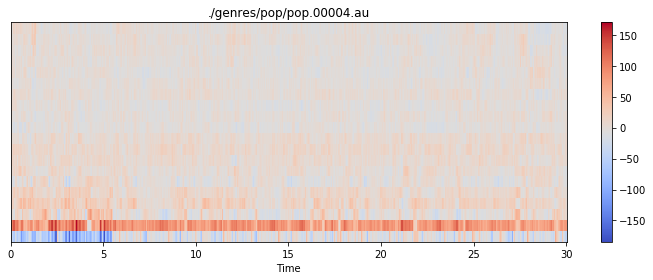

In [5]:
audio_path = './genres/pop/pop.00004.au'
y, sr = librosa.load(audio_path)
#mfcc = librosa.feature.mfcc(y)
mfcc = librosa.feature.mfcc(y, n_mfcc=20, hop_length= 512, n_fft=2048)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time')
#plt.pcolormesh(mfcc)
plt.colorbar()
plt.title(audio_path)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'MFCC for pop.00004')

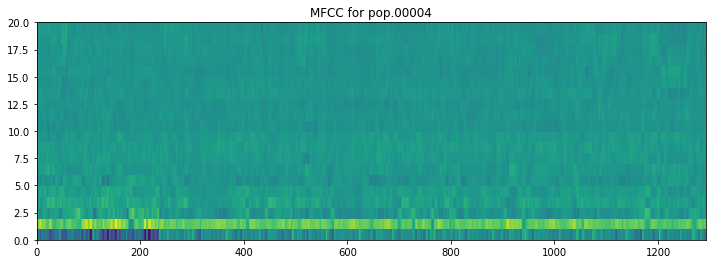

In [7]:
plt.figure(figsize=(12, 4))
plt.pcolormesh(mfcc)
#plt.colorbar()
plt.title('MFCC for pop.00004')

In [4]:
mfcc.shape

(20, 1293)

In [8]:
delta_mfcc = librosa.feature.delta(mfcc)

In [9]:
delta_mfcc.shape

(20, 1293)

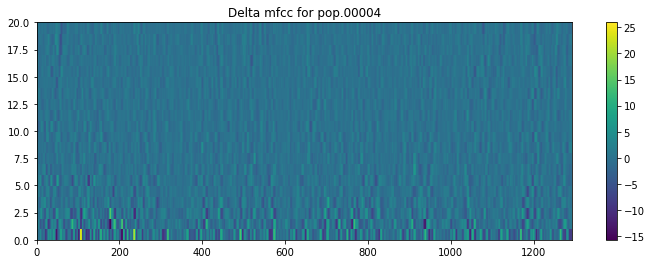

In [11]:
#plt.pcolormesh(delta_mfcc)
plt,ax = 
plt.figure(figsize=(12, 4))
plt.pcolormesh(delta_mfcc)
plt.title('Delta mfcc for pop.00004')
plt.show()

In [12]:
delta2_mfcc =  librosa.feature.delta(mfcc,order=2)

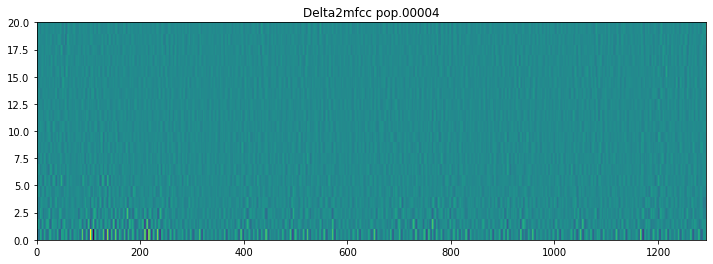

In [14]:
#plt.pcolormesh(delta2_mfcc)
plt.figure(figsize=(12, 4))
plt.pcolormesh(delta2_mfcc)

plt.title('Delta2mfcc pop.00004')
plt.show()

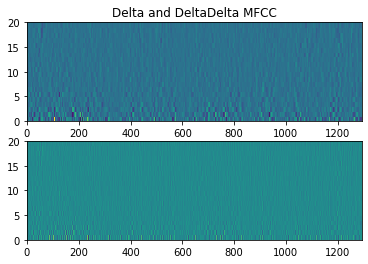

In [32]:
fig,ax = plt.subplots(nrows=2)
ax[0].pcolormesh(delta_mfcc)

ax[1].pcolormesh(delta2_mfcc)
ax[0].title.set_text('Delta and DeltaDelta MFCC')

#ax[1].title.set_text('Delta Delta MFCC')

In [12]:
delta2_mfcc.shape

(20, 1293)

In [13]:
mfcc = np.concatenate((mfcc, delta_mfcc,delta2_mfcc),axis=0)

In [14]:
mfcc.shape

(60, 1293)

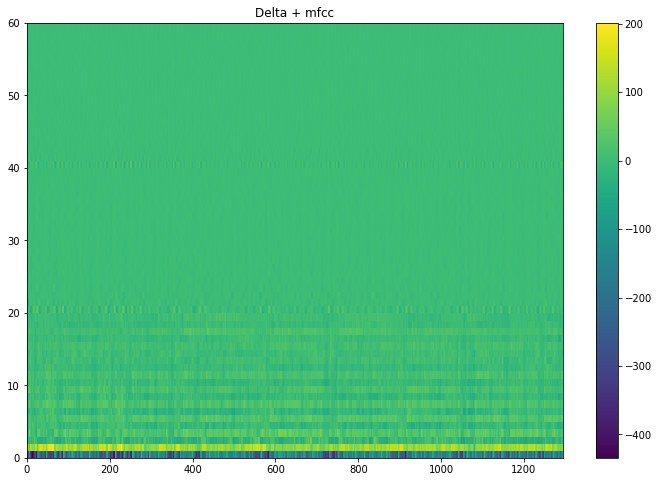

In [15]:
plt.figure(figsize=(12, 8))
plt.pcolormesh(mfcc)
plt.colorbar()
plt.title('Delta + mfcc')
plt.show()

In [13]:
def extract_features_song(f,duration=30.0):
    y, sr = librosa.load(f)

    # get Mel-frequency cepstral coefficients
    mfcc = librosa.feature.mfcc(y, n_mfcc=20, hop_length= 512, n_fft=2048)
    # normalize values between -1,1 (divide by max)
    #mfcc /= np.amax(np.absolute(mfcc))
    #print(mfcc.shape)
    #return np.ndarray.flatten(mfcc)[:25000]
    delta_mfcc = librosa.feature.delta(mfcc)
    delta2_mfcc =  librosa.feature.delta(mfcc,order=2)
    mfcc = np.concatenate((mfcc, delta_mfcc,delta2_mfcc),axis=0)
    
    return mfcc[:,:1290]

def generate_features_and_labels():
    all_features = []
    all_labels = []

    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
   # genres = ['reggae']
    for genre in genres:
        sound_files = glob.glob('genres/'+genre+'/*.au')
        print('Processing %d songs in %s genre...' % (len(sound_files), genre))
        for f in sound_files:
            features = extract_features_song(f)
            #print(features.shape)
            all_features.append(features)
            all_labels.append(genre)
    
    # convert labels to one-hot encoding
    label_uniq_ids, label_row_ids = np.unique(all_labels, return_inverse=True)
    label_row_ids = label_row_ids.astype(np.int32, copy=False)
    onehot_labels = to_categorical(label_row_ids, len(label_uniq_ids))
    return np.stack(all_features), onehot_labels
    
    #return all_features, all_labels

In [14]:
features, labels = generate_features_and_labels()

Processing 100 songs in blues genre...
Processing 100 songs in classical genre...
Processing 100 songs in country genre...
Processing 100 songs in disco genre...
Processing 100 songs in hiphop genre...
Processing 100 songs in jazz genre...
Processing 100 songs in metal genre...
Processing 100 songs in pop genre...
Processing 100 songs in reggae genre...
Processing 100 songs in rock genre...


In [27]:
np.savez("./mfcc_with_labels.npz", MFCC=features, labels=labels)


In [15]:
features.shape

(1000, 60, 1290)

In [16]:
np.savez("./mfcc_delta_with_labels.npz", MFCC=features, labels=labels)

In [2]:
with np.load('mfcc_with_labels.npz',allow_pickle=True) as data:
    X = data['MFCC']
    y = data['labels']

In [3]:
X.shape

(1000, 20, 1290)

In [6]:
y.shape

(1000, 10)

In [29]:
with np.load('mfcc_delta_with_labels.npz',allow_pickle=True) as data:
    X = data['MFCC']
    y = data['labels']

In [30]:
X.shape

(1000, 60, 1290)

# Dynamic MFCC

In [7]:

def get_d_features(data):
    '''
    Dynamic features: stack 7 MFCC or filterbank features symmetrically distributed around the current time step. 
    At time n, stack the features at times [n − 3, n − 2, n − 1, n, n + 1, n + 2, n + 3]). 
    At the beginning and end of each utterance, use mirrored feature vectors in place of the missing vectors.
    '''
    D_lmfcc = data[0].shape[0]
    N = data.shape[0]*data.shape[2] 
 
    mfcc_features = np.zeros((N,D_lmfcc*7))
    
    k = 0
    for x in data: 
        n_frames, dim = x.T.shape
        ## for each timestep
        for i in range(n_frames):
            if i< 3 or i >= n_frames-3:
                mfcc_features[k,:] = np.hstack(np.pad(x.T, pad_width=((3, 3), (0, 0)), mode='reflect')[i:i+7,:])
            else:
                mfcc_features[k,:] = np.hstack(x.T[i-3:i+4,:])
       
            k +=1
    
    return mfcc_features

In [15]:
def get_d_features(data):
    mfcc_features = np.zeros((1000,140,1290))
    for i in range(1000):
        for j in range(1290):
            for k in range(20):
                if k < 3 or k >= 17:
                    mfcc_features[i,k*7:k*7+7,j] = np.pad(X[i,:,j],(3, 3),mode='reflect')[k:k+7]
                else:
                    mfcc_features[i,k*7:k*7+7,j] = X[i,k-3:k+4,j]
    
    return mfcc_features

In [16]:
d_lmfcc = get_d_features(X)

In [17]:
d_lmfcc.shape

(1000, 140, 1290)

In [10]:
d_lmfcc = d_lmfcc.reshape(1000,1290,140)


In [21]:
n_frames, dim = X[0].T.shape
n_frames

1290

In [12]:
d_lmfcc.reshape(-1,140)

array([[-120.67938995,  120.32298279,  -17.75279617, ...,   13.59334373,
          -1.10969281,    1.90863895],
       [-117.57201385,  113.41286469,  -16.68023872, ...,   15.84359932,
           0.93487895,   -1.51465499],
       [-104.38738251,  105.30064392,   -7.17233515, ...,   16.33520317,
           1.65781569,   -0.82951981],
       ...,
       [ -86.17105103,   65.67939758,  -24.10117722, ...,   -2.93348503,
          -5.7395153 ,   -3.62540627],
       [ -96.83666992,   75.20553589,  -23.3287735 , ...,    2.38519406,
          -1.23981881,   -5.73573828],
       [-112.6370697 ,   76.49188232,  -18.69802856, ...,    5.91623831,
          -3.19250631,   -6.89105511]])

In [19]:
print(X[0][0][3],X[0][0][2],X[0][0][1], X[0][0][0], X[0][0][1], X[0][0][2], X[0][0][3]) 

-120.67939 -117.572014 -104.38738 -98.996414 -104.38738 -117.572014 -120.67939


In [25]:
d_lmfcc[0][0]

array([-1.20679390e+02,  1.20322983e+02, -1.77527962e+01,  4.41309433e+01,
       -1.40988197e+01,  3.11667519e+01, -3.03604627e+00,  3.34247665e+01,
       -7.30821133e+00, -4.03407574e+00, -2.41495609e+01,  1.82403297e+01,
       -8.92314672e-01,  1.32291532e+00, -2.11236706e+01,  4.22646141e+00,
        1.47359788e+00,  1.35933437e+01, -1.10969281e+00,  1.90863895e+00,
       -1.17572014e+02,  1.13412865e+02, -1.66802387e+01,  4.86146164e+01,
       -1.07155018e+01,  3.14176159e+01, -4.20484066e+00,  3.44948044e+01,
       -5.98754978e+00, -2.99812078e+00, -2.10679951e+01,  1.82317905e+01,
        1.29119945e+00,  3.28533602e+00, -2.17491951e+01,  6.56276751e+00,
        9.62631941e-01,  1.65518112e+01, -8.57182205e-01,  2.67613316e+00,
       -1.04387383e+02,  1.05300644e+02, -7.17233515e+00,  4.39017868e+01,
       -3.10982609e+00,  2.82016335e+01,  2.02392459e-01,  2.85335045e+01,
        4.92154121e+00, -7.72453594e+00, -1.83263645e+01,  6.70205593e+00,
        4.85795832e+00,  

In [18]:
np.savez("./dynamic_mfcc_with_labels.npz", MFCC=d_lmfcc, labels=y)

# Modeling baseline

In [ ]:
X = get_features()

In [105]:
with np.load('dynamic_mfcc_with_labels.npz',allow_pickle=True) as data:
    X = data['MFCC']
    y = data['labels']

In [106]:
X.shape

(1000, 1290, 140)

In [19]:
X_f = np.ndarray.flatten(d_lmfcc).reshape(1000,-1)

In [20]:
X_f.shape

(1000, 180600)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_f, y, test_size=0.2)

In [22]:
scaler = StandardScaler()
scaler.fit(np.array(X_train, dtype = float))
scaler.transform(X_train)
scaler.transform(X_test)

array([[-1.26600658, -1.27986209, -1.0918886 , ...,  0.54327875,
         0.42757161,  0.39925697],
       [ 1.02061682,  0.82234183,  0.4652856 , ...,  1.16203116,
         1.05112531,  0.87736419],
       [-0.85102142, -0.84186785, -0.51936037, ..., -0.55716654,
        -0.29843351, -0.60793929],
       ...,
       [ 1.84613082,  1.79532213,  1.69864374, ...,  1.08447265,
         0.06939691, -1.42479963],
       [-1.21985734, -1.04435044, -0.90466132, ..., -0.45059796,
         0.07293285,  0.37098365],
       [ 0.42252047,  0.9797323 ,  1.7300842 , ..., -1.31226365,
        -0.84870491,  0.23646873]])

In [23]:
from keras import regularizers

model = models.Sequential()
#model.add(layers.Dropout(0.25))
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],), 
                       kernel_regularizer=regularizers.l2(0.001)))
       
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.Dense(10, activation='softmax'))

In [24]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               46233856  
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                2570      
Total params: 46,368,010
Trainable params: 46,368,010
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.25)

Train on 600 samples, validate on 200 samples
Epoch 1/20
600/600 [==============================] - 34s 57ms/step - loss: 1696.1447 - acc: 0.1567 - val_loss: 955.4485 - val_acc: 0.1600
Epoch 2/20
600/600 [==============================] - 45s 74ms/step - loss: 468.6997 - acc: 0.3433 - val_loss: 253.0592 - val_acc: 0.3350
Epoch 3/20
600/600 [==============================] - 36s 59ms/step - loss: 129.0310 - acc: 0.5150 - val_loss: 167.2714 - val_acc: 0.3750
Epoch 4/20
600/600 [==============================] - 28s 47ms/step - loss: 51.6109 - acc: 0.6850 - val_loss: 132.1901 - val_acc: 0.4000
Epoch 5/20
600/600 [==============================] - 28s 47ms/step - loss: 36.0591 - acc: 0.7183 - val_loss: 135.0027 - val_acc: 0.4350
Epoch 6/20
600/600 [==============================] - 32s 54ms/step - loss: 12.1572 - acc: 0.8767 - val_loss: 89.6494 - val_acc: 0.5250
Epoch 7/20
600/600 [==============================] - 31s 52ms/step - loss: 15.0150 - acc: 0.8550 - val_loss: 129.6522 - val_acc:

In [14]:
results = model.evaluate(X_test, y_test)

200/200 [==============================] - 0s 1ms/step


In [21]:
results

[84.07220428466798, 0.4950000047683716]

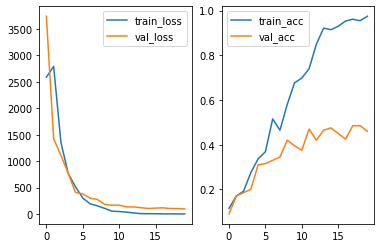

In [22]:
fig,ax = plt.subplots(ncols=2)

ax[0].plot(history.history['loss'],label='train_loss')
ax[0].plot(history.history['val_loss'],label='val_loss')
ax[0].legend()
ax[1].plot(history.history['acc'],label='train_acc')
ax[1].plot(history.history['val_acc'],label='val_acc')
ax[1].legend()
plt.show()

In [85]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.25)

Train on 600 samples, validate on 200 samples
Epoch 1/20
600/600 [==============================] - 14s 23ms/step - loss: 1805.5141 - acc: 0.1500 - val_loss: 2006.2244 - val_acc: 0.2150
Epoch 2/20
600/600 [==============================] - 10s 17ms/step - loss: 2169.4483 - acc: 0.1883 - val_loss: 1393.7868 - val_acc: 0.2550
Epoch 3/20
600/600 [==============================] - 9s 15ms/step - loss: 780.5202 - acc: 0.2583 - val_loss: 663.7210 - val_acc: 0.1700
Epoch 4/20
600/600 [==============================] - 9s 14ms/step - loss: 411.9962 - acc: 0.2967 - val_loss: 434.5006 - val_acc: 0.3250
Epoch 5/20
600/600 [==============================] - 8s 14ms/step - loss: 308.2657 - acc: 0.3950 - val_loss: 352.4587 - val_acc: 0.3350
Epoch 6/20
600/600 [==============================] - 9s 15ms/step - loss: 215.5973 - acc: 0.4533 - val_loss: 245.4729 - val_acc: 0.3600
Epoch 7/20
600/600 [==============================] - 9s 14ms/step - loss: 119.7342 - acc: 0.5533 - val_loss: 185.6134 - val_a

In [86]:
 model.evaluate(X_test, y_test)

200/200 [==============================] - 1s 7ms/step


[114.06183471679688, 0.4300000071525574]